<a href="https://colab.research.google.com/github/Eman-Nasr/Data/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import json  # For saving training history

# Define image parameters
img_height, img_width = 150, 150
batch_size = 32

# Reload the dataset (same as before)
new_train_ds_raw = keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/insect",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

new_val_ds = keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/insect",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names
class_names = new_train_ds_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Apply Data Augmentation
new_data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

# Apply augmentation to training dataset
new_train_ds = new_train_ds_raw.map(lambda x, y: (new_data_augmentation(x, training=True), y))

# Load Pre-trained MobileNetV2 Model
mobilenet_base = keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                include_top=False,
                                                weights='imagenet')

mobilenet_base.trainable = False  # Freeze pre-trained layers

# Build New Model Using MobileNetV2
mobilenet_model = keras.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile Model
mobilenet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Save Training Progress (Checkpoint)
checkpoint_mobilenet = "/content/drive/My Drive/mobilenet_checkpoint.keras"
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_mobilenet,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max')

# Learning Rate Adjustment
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train Model
epochs = 20
history_mobilenet = mobilenet_model.fit(new_train_ds, validation_data=new_val_ds, epochs=epochs,
                                        callbacks=[checkpoint_callback, lr_scheduler])

# Save the new MobileNetV2 Model
mobilenet_path = "/content/drive/My Drive/insect_classifier_mobilenet.keras"
mobilenet_model.save(mobilenet_path)
print("MobileNetV2 Model saved at", mobilenet_path)

# Save Training History
history_file = "/content/drive/My Drive/mobilenet_training_history.json"

with open(history_file, "w") as f:
    json.dump(history_mobilenet.history, f)

print("Training history saved at", history_file)


Mounted at /content/drive
Found 6772 files belonging to 2 classes.
Using 5418 files for training.
Found 6772 files belonging to 2 classes.
Using 1354 files for validation.
Classes: ['harmful', 'not_harm']


<ipython-input-1-1cea34037334>:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.6606 - loss: 0.8845 - val_accuracy: 0.7334 - val_loss: 0.5432 - learning_rate: 1.0000e-04
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7452 - loss: 0.5490 - val_accuracy: 0.7784 - val_loss: 0.4853 - learning_rate: 1.0000e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7719 - loss: 0.5027 - val_accuracy: 0.7622 - val_loss: 0.5050 - learning_rate: 1.0000e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7818 - loss: 0.4905 - val_accuracy: 0.7696 - val_loss: 0.4984 - learning_rate: 1.0000e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7808 - loss: 0.4847 - val_accuracy: 0.7341 - val_loss: 0.5322 - learning_rate: 1.0000e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7744 - loss: 0.4809 - val_accuracy: 0.7408 - val_loss: 0.5352 - learning_rate: 1.0000e-04
Epoch 7/2

In [ ]:
import os
model_path = "/content/drive/My Drive/insect_classifier_xception.keras"
print("File exists:", os.path.exists(model_path))


File exists: False


Training history loaded successfully!


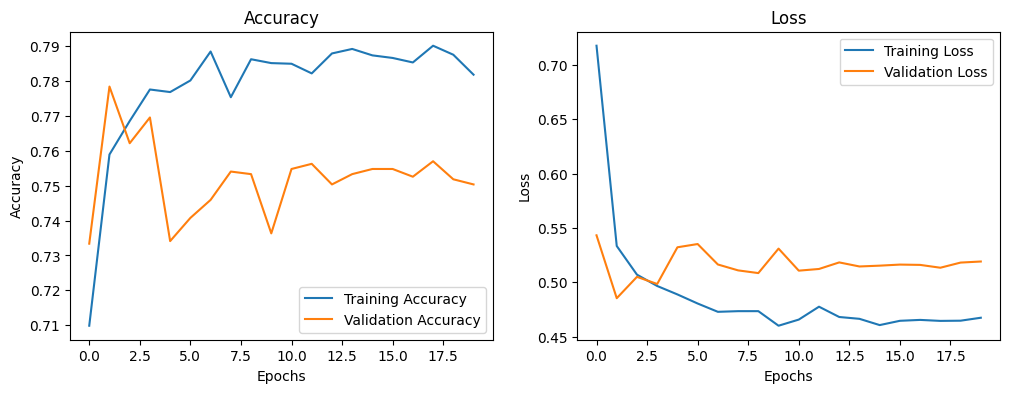

In [ ]:
import json
import matplotlib.pyplot as plt

# Load training history
history_file = "/content/drive/My Drive/mobilenet_training_history.json"

try:
    with open(history_file, "r") as f:
        history_dict = json.load(f)
    print("Training history loaded successfully!")
except:
    print("No training history found. Retraining might be required.")

# Extract accuracy and loss values
train_acc = history_dict.get('accuracy', [])
val_acc = history_dict.get('val_accuracy', [])
train_loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

# Plot Accuracy and Loss
if train_acc and val_acc and train_loss and val_loss:
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
else:
    print("No training history available to plot.")


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the path to the saved model
model_path = "/content/drive/My Drive/insect_classifier_mobilenet.keras"

# Load the trained model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Reload validation dataset (for evaluation)
img_height, img_width = 150, 150
batch_size = 32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/insect",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names
class_names = val_ds.class_names
print("Classes:", class_names)

# Convert dataset into NumPy arrays for evaluation
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


ValueError: File not found: filepath=/content/drive/My Drive/insect_classifier_mobilenet.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
import os

model.save("/content/drive/My Drive/risk_classifier.keras")
model.save("/content/drive/My Drive/harmful_insect_classifier.keras")
model.save("/content/drive/My Drive/not_harm_insect_classifier.keras")

print(os.path.exists("/content/drive/My Drive/risk_classifier.keras"))
print(os.path.exists("/content/drive/My Drive/harmful_insect_classifier.keras"))
print(os.path.exists("/content/drive/My Drive/not_harm_insect_classifier.keras"))



True
True
True


In [ ]:
pip install tensorflow matplotlib numpy


Saving Image_1.jpg to Image_1 (3).jpg
✅ Image uploaded and saved as: /content/Image_1 (3).jpg
Found 6772 files belonging to 2 classes.
✅ Loaded class names: ['harmful', 'not_harm']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🟢 Raw Predictions: [[0.1736278  0.82637215]]
🟢 Predicted Class Index: 1
🟢 Predicted Class: not_harm


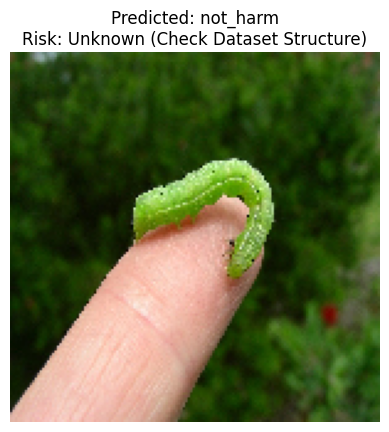

✅ Predicted Insect: not_harm
✅ Risk Category: Unknown (Check Dataset Structure)


In [ ]:
from google.colab import files
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Upload an Image
uploaded = files.upload()  # Manually select an image

# Get the first uploaded filename
test_image_path = list(uploaded.keys())[0]

# Move it to a known location to avoid conflicts
image_path = f"/content/{test_image_path}"
shutil.move(test_image_path, image_path)

print(f"✅ Image uploaded and saved as: {image_path}")

# Step 2: Load the Trained Model
model_path = "/content/drive/My Drive/insect_classifier_mobilenet.keras"
model = keras.models.load_model(model_path)

# Step 3: Get the Correct Class Names from the Dataset Structure
dataset_path = "/content/drive/My Drive/insect"
temp_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_path, batch_size=1, image_size=(150, 150), shuffle=False
)
class_names = temp_ds.class_names  # Get class names directly from dataset
print(f"✅ Loaded class names: {class_names}")

# Step 4: Preprocess the Uploaded Image
img_height, img_width = 150, 150
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Step 5: Predict the Insect Type
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Debugging: Print Raw Predictions
print(f"🟢 Raw Predictions: {predictions}")
print(f"🟢 Predicted Class Index: {predicted_class_index}")
print(f"🟢 Predicted Class: {predicted_class}")

# Step 6: Assign Harmful or Not Based on Correct Folder Mapping
harmful_classes = [
    "Africanized Honey Bees (Killer Bees)", "Aphids", "Armyworms",
    "Brown Marmorated Stink Bugs", "Cabbage Loopers", "Citrus Canker",
    "Colorado Potato Beetles", "Corn Borers", "Corn Earworms",
    "Fall Armyworms", "Fruit Flies", "Spider Mites", "Thrips",
    "Tomato Hornworms", "Western Corn Rootworms"
]

not_harmful_classes = [
    "ants", "bees", "beetle", "caterpillar", "earwig", "grasshopper",
    "moth", "slug", "snail", "wasp", "weevil"
]

if predicted_class in harmful_classes:
    risk_category = "Harmful"
elif predicted_class in not_harmful_classes:
    risk_category = "Not Harmful"
else:
    risk_category = "Unknown (Check Dataset Structure)"

# Step 7: Display Prediction Results
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}\nRisk: {risk_category}")
plt.show()

print(f"✅ Predicted Insect: {predicted_class}")
print(f"✅ Risk Category: {risk_category}")
